In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score

/var/folders/n9/c8x8hdwj3rq05yzhrqxbkc7h0000gn/T/ipykernel_24316/4284088062.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
df=pd.read_csv("/Users/chenxiaofeng/Desktop/cleaned_heart_data.csv")

In [3]:
df=df.drop(columns=["State","HadHeartAttack"])
columns_to_convert = ['PhysicalActivities',"HadAngina","HadStroke","HadAsthma","HadCOPD","HadKidneyDisease","HadArthritis","AlcoholDrinkers"]  # List your columns here

for column in columns_to_convert:
    df[column] = df[column].str.strip().str.lower().replace({'yes': 1, 'no': 0})

In [4]:
df["GeneralHealth"].replace({'Poor':0,'Fair':1,'Good':2,'Very good':3,'Excellent':4},inplace=True) 

df["SmokerStatus"].replace({"Never":0,'Sometimes':1,'Former':2,"Everyday":3},inplace=True) 

df["AgeCategory"].replace({'18-24':0,'25-29':1,'30-34':2,'35-39':3,'40-44':4,'45-49':5,'50-54':6,'55-59':7,'60-64':8,'65-69':9,'70-74':10,'75-79':11,'80+':12},inplace=True) 

df["SleepCategory"].replace({'Very Short':0,'Short':1,'Recommended':2,'Long':3,'Very Long':4},inplace=True)

In [5]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()
categorical_columns = ['Sex']
encoded_features = encoder.fit_transform(df[categorical_columns]).toarray()

encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out())

df = df.drop(categorical_columns, axis=1)
df = pd.concat([df, encoded_df], axis=1)

In [6]:
from sklearn.model_selection import train_test_split
y = df.pop('HadHeartAttackNumeric')
X = df
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=499)

In [7]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [8]:
import tensorflow as tf
from tensorflow.keras import layers
model = tf.keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    layers.Dropout(0.2),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])


history = model.fit(X_train_scaled, y_train, epochs=100, validation_split=0.2, verbose=1)


test_loss, test_acc = model.evaluate(X_test_scaled, y_test, verbose=2)
print('\nTest accuracy:', test_acc)

Epoch 1/100
7430/7430 ━━━━━━━━━━━━━━━━━━━━ 3s 379us/step - accuracy: 0.9463 - loss: 0.1581 - val_accuracy: 0.9507 - val_loss: 0.1421
Epoch 2/100
7430/7430 ━━━━━━━━━━━━━━━━━━━━ 3s 370us/step - accuracy: 0.9487 - loss: 0.1468 - val_accuracy: 0.9508 - val_loss: 0.1424
Epoch 3/100
7430/7430 ━━━━━━━━━━━━━━━━━━━━ 3s 370us/step - accuracy: 0.9482 - loss: 0.1471 - val_accuracy: 0.9517 - val_loss: 0.1418
Epoch 4/100
7430/7430 ━━━━━━━━━━━━━━━━━━━━ 3s 371us/step - accuracy: 0.9484 - loss: 0.1461 - val_accuracy: 0.9516 - val_loss: 0.1416
Epoch 5/100
7430/7430 ━━━━━━━━━━━━━━━━━━━━ 3s 373us/step - accuracy: 0.9483 - loss: 0.1458 - val_accuracy: 0.9510 - val_loss: 0.1416
Epoch 6/100
7430/7430 ━━━━━━━━━━━━━━━━━━━━ 3s 372us/step - accuracy: 0.9483 - loss: 0.1471 - val_accuracy: 0.9518 - val_loss: 0.1420
Epoch 7/100
7430/7430 ━━━━━━━━━━━━━━━━━━━━ 3s 372us/step - accuracy: 0.9502 - loss: 0.1443 - val_accuracy: 0.9511 - val_loss: 0.1414
Epoch 8/100
7430/7430 ━━━━━━━━━━━━━━━━━━━━ 3s 362us/step - accuracy: 

In [10]:
from sklearn.metrics import classification_report

y_pred_probs = model.predict(X_test_scaled)
y_pred = [1 if prob > 0.5 else 0 for prob in y_pred_probs.ravel()]

print(classification_report(y_test, y_pred))

2322/2322 ━━━━━━━━━━━━━━━━━━━━ 1s 201us/step
              precision    recall  f1-score   support

           0       0.96      0.99      0.97     70254
           1       0.56      0.20      0.30      4038

    accuracy                           0.95     74292
   macro avg       0.76      0.60      0.64     74292
weighted avg       0.93      0.95      0.94     74292



In [11]:
y_pred_probs = model.predict(X_test_scaled).ravel()

2322/2322 ━━━━━━━━━━━━━━━━━━━━ 1s 196us/step


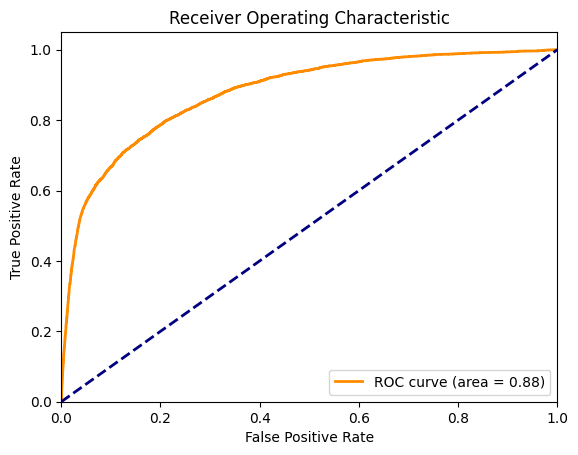

In [12]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()
